# Resolución de problema mediante búsqueda heurística
# Integrantes del grupo

Grupo de estudios: 12 - FUNDAE

Listado de integrantes:
- Beatriz Garcia Collado
- Manuel Naranjo Martínez
- Óscar Martínez Olmos
- Pablo David Lombardo Papi
- Santiago Félix Eslava Ros

# Librerias

Importamos todas las librerías que vamos a utilizar durante la ejecución

In [20]:
%matplotlib inline
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw        
import cv2
import os
import glob

# Análisis Inicial
Se asume que el robot solo va a poder moverse en cruz siempre y cuando tengas espacio disponible. En caso de que esté transportando una carga tampoco podrá pasar por encima de las demás cargas. Además, en caso de necesitarlo, el robot podrá soltar una carga en cualquier sitio aunque no sea su objetivo final.
Para la solución del ejericio, se va a representar el almacen mediante la siguiente matriz. El significado de las casillas de la matriz es el siguiente:
<ol>
    <li><b>R</b>: la posición del Robot
    <li><b>#</b>: la posición de una pared
    <li><b>M1,M2,M3</b>: la posición de las distintas cargas
    <li><b>0</b>: espacio vacío     
</ol>

In [39]:
INIT_STATE = [["M1", "#",  0 , "M3"],
			  [ 0  , "#",  0 ,  0  ],
			  [ 0  ,  0 , "R",  0  ],
			  ["M2",  0 ,  0 ,  0  ]]

GOAL_STATE = [[ 0 , "#" ,  0  ,  0  ],
			  [ 0 , "#" ,  0  ,  0  ],
			  [ 0 ,  0  , "R" ,  0  ],
			  [ 0 , "M3", "M2", "M1"]]  

## Presentacion de resultados

Para representar de una manera más visual el almacén utilizaremos las siguientes funciones que traducirán la matriz a imágenes

In [22]:
def createImg(estado, escala = 100):
    """
    Crea una imagen representando el estado del almacen
    
    Args: 
        estado (np.array): estado actual del almacen 
        escala (int): la escala en la que se muestra la imagen
    Return:
        la imagen resultante
    """
    filas, columnas = estado.shape
    img = Image.new("RGB",(columnas*escala + 2, filas*escala + 2),(255,255,255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", int(32*escala/100))
    for i in range(filas + 1):
        draw.line(xy = (0, i*escala, columnas*escala, i*escala), fill = (0,0,0))
    for i in range(columnas + 1):
        draw.line(xy = (i*escala, 0, i*escala, filas*escala), fill = (0,0,0))
    for (y,x), value in np.ndenumerate(estado):
        if value != 0:
            if str(value) == "#":
                color = (0, 255, 0)
            elif "R" in str(value) :
                color = (255, 0, 0)
            else:
                color = (0, 0, 255)
            draw.text((escala/2 + x*escala - int(16*escala/100),escala/2 + y*escala),value,color,font=font)
    return img

def show_images(*images):
    """
    Muestra una lista dinámica de imagenes
    
    Args: 
        images (np.array): Las imagenes que se quieren visualizar
    """
    img_list = list(images)
    fig, axis = plt.subplots(ncols = len(img_list), figsize=(16,10), sharex=True, sharey=True)
    for i, ax in enumerate(axis):
        ax.imshow(images[i])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_adjustable('box')

#### Visualizacion del estado inicial y final en imágenes

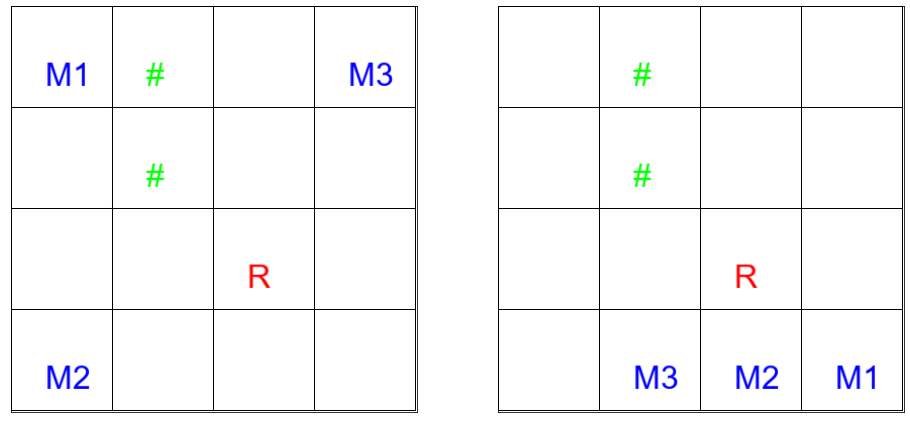

In [44]:

show_images(createImg(np.array(INIT_STATE, dtype=object),100), createImg(np.array(GOAL_STATE, dtype=object),100))

# Plan de acción

Para solucionar el problema utilizaremos un Agente, al que le daremos las reglas que puede seguir, el estado inicial y el estado final.

El Agente realizará una **búsqueda A*** y devolverá la lista de estados que ha tenido que recorrer para conseguir llegar al resultado final. 

Por último, para presentar los movimientos de nuestro agente, crearemos una lista de imágenes con los estados y las transformaremos a vídeo.

In [23]:
def main(c_avance, c_carga, video_title, save_historic):
    """
    Función principal para lanzar nuestra solución
    
    Args:
        c_avance (int): coste de avance
        c_carga (int): coste de carga
        video_title (str): Título para generar el vídeo
        save_historic (boolean): Permite guardar el historico de como se resuelve el problema
    """
    agent = Agent(Rules().getRules(), INIT_STATE, GOAL_STATE)
    result = agent.heuristicSearch(c_avance, c_carga, save_historic)    
    images = []                   
    while result is not None:
        img = createImg(result.state, 100)
        images.insert(0,img)
        result = result.prevNode
        
    createVideo(video_title, images, 2)
    createVideo("HeuristicSearch", agent.imgList, 7)
    
    #print("COSTE AVANCE ->",c_avance, "COSTE CARGA INCORRECTA -> " ,c_carga, "LARGO -> ", len(path), "Tiempo -> ", end-start)
                  

In [24]:
class Agent:
    """
    Clase para representar a un agente (Robot)
    que será el encargado de llevar las cargas
    desde su posición inicial a la final
    
    Attributes
    ----------
    openDict : dic
        Diccionario para controlar los elementos abiertos
    closeDict : dic
        Diccionario para controlar los elementos cerrados
    openList : list
        ..... Lista de elementos que se van a revisar a continuación
    init_state : Almacen
        Representa el estado inicial con un objeto Almacen
    final_state : Almacen
        Representa el estado final con un objeto Almacen
    rules : Rule
        Reglas de movimiento del agente
    
    Methods
    -------
    reset()
        Resetea el estado de nuestro agente
    calcScore()
        Calcula el rendimiento de un estado del almacen
    heuristicSearch()
        Reliza la busqueda heuristica con los parametros especificados al agente
    """
    def __init__(self, rules, init_state, final_state):
        self.openDict = {}
        self.closeDict = {}
        self.openList = list()
        self.closeList = list()
        self.imgList = list()
        self.init_state = Almacen(init_state, None)
        self.final_state = Almacen(final_state, None)
        self.rules = rules
        
    def reset(self):
        """
        Resetea los argumentos del agente
        """
        self.openDict = {}
        self.closeDict =  {}
        self.imgList.clear()
        self.openList.clear()
        self.closeList.clear()
        self.openDict[self.init_state.getId()] =  1
        self.openList.append(self.init_state);
        
        self.openIt = iter(self.openList)
 



Para que el Agente pueda crear una lista de nodos con todos los estados del almacén se ha encapsulado el estado del almacén en una clase que guardara también el nodo anterior del almacén, una puntuación y un ID único creado a partir del estado.

In [25]:
class Almacen:
    """
    Clase para representar a un agente (Robot)
    que será el encargado de llevar las cargas
    desde su posición inicial a la final
    
    Attributes
    ----------
    state : matrix
        Una matríz que representa el estado específico de cada Almacen
    prevNode : Almacen
        Nodo del estado anterior  
    score : float
        Puntuación con la que se clasifíca el rendimiento de cada estado
        
    Methods
    -------
    getId()
        Devuelve el Id del estado
    """
    def __init__(self, state, prevNode):
        self.state = np.array(state, dtype=object)
        self.prevNode = prevNode
        self.score = 0
        
    def getId(self):
        """
        Función para obtener el Id del estado
        """
        m_id = ""
        for _,s in np.ndenumerate(self.state):
            m_id += str(s)
        return m_id


Las reglas son las encargadas de crear nuevos nodos. A cada regla se le asignará una direccion y la opcion de poder soltar o no una carga. Cada regla tomará un estado, hará una copia del mismo, buscará el robot, moverá el valor de la celda en la que se encuentra el robot en la direccion que le hayamos asignado y pondrá 0 donde estaba anteriormete el robot. En caso de que le hayamos dicho a la regla que tiene que soltar la carga, en lugar de mover el valor de la celda, moverá solo la "R" y quitandola de la casilla en la que se encontraba. En caso de que el robot no se pueda mover en dicha direccion por haber llegado al limite del almacen, por haber chocado con una pared o por haber chocado con una carga mientras estaba moviendo otra carga, no creará un nuevo estado. 

In [26]:
class Rule():
    """
    Clase encargadas de crear nuevos nodos
    
    Attributes
    ----------
    dx : int
        Especifica cuanto se va a mover el robot en la coordenada x
    dy : int
        Especifica cuanto se va a mover el robot en la coordenada y
    leaveLoad : boolean
        Especifica si al moverse el robot va a dejar la carga en su sitio o se la va a llevar consigo
        
    Methods
    ----------
    execute()
        Encargado de ejecutar las reglas sobre el 
        elemento 'Almacen'
    """
    def __init__(self,dx,dy, leaveLoad):
        self.dx = dx;
        self.dy = dy;
        self.leaveLoad = leaveLoad
   
               
    def execute(self, almacen: Almacen) -> Almacen:
        """
        Función encargada de ejecutar las reglas sobre el 
        elemento 'Almacen'
        
        Args:
            almacen (Almacen) : El almacen sobre el que se quiere ejecutar la regla
        """
        columnas = len(almacen.state[0,:])
        filas = len(almacen.state[:,0])
        x,y = findState(almacen.state, 'R')[0]
        
        if y + self.dy < 0 or y + self.dy >= columnas:
            return None
        
        if x + self.dx < 0 or x + self.dx >= filas:
            return None
        
        anterior = str(almacen.state[y,x])
        nuevaPos = str(almacen.state[y + self.dy, x + self.dx])
        
        nuevoEstado = almacen.state.copy()
        if nuevaPos == "#":
            return None
        if self.leaveLoad:
            if not 'M' in anterior:
                return None
            else:
                nuevoEstado[y,x] = anterior.replace('R','')  
                anterior = 'R'
        else:        
            nuevoEstado[y,x] = 0         
        if nuevaPos == '0':
            nuevoEstado[y + self.dy, x + self.dx] = anterior
            return Almacen(nuevoEstado, almacen)
        
        if "M" in nuevaPos:            
            if "M" in anterior:
                return None
            nuevoEstado[y + self.dy, x + self.dx] = anterior + nuevaPos
            return Almacen(nuevoEstado, almacen)
        

Se crearan 8 reglas. 4 para cada direccion ortogonal sin soltar la carga y 4 para cada direccion ortogonal soltando la carga 

In [27]:
class Rules:
    """
    Factoria de reglas que el robot utilizará para moverse por el almacen. 
    
    Methods: 
    ------
        getRules()
    """
    def __init__(self):
        self.ruleList = list()
        self.ruleList.append(Rule(0,-1, False))
        self.ruleList.append(Rule(0, 1, False))
        self.ruleList.append(Rule(-1,0, False))
        self.ruleList.append(Rule(1, 0, False))
        self.ruleList.append(Rule(0,-1, True))
        self.ruleList.append(Rule(0, 1, True))
        self.ruleList.append(Rule(-1,0, True))
        self.ruleList.append(Rule(1, 0, True))
        
    def getRules(self):
        """
        Funcion para obtener la lista de las reglas definidas en la clase
        Return:
            La lista de las reglas
        """
        return self.ruleList
        


Una de las claves para conseguir una búsqueda óptima del resultado, es asignar una puntuación a cada estado, la cual represente lo cerca que está de llegar al resultado final. En este caso se ha utilizado una función heurística que conbina 4 costes diferentes:

* **La distancia manhattan**: Es una función que irá incrementando de valor por cada casilla que se mueva el robot. Esto nos sirve para encontrar el camino más corto, priorizando los nodos en los que se ha movido menos el robot.
* **La distancia hamming**: Es una funcion que va incrementando por cada carga que no esté en su sitio. Este coste sirve para priorizar los nodos que tienen cargas bien colocadas.
* **La distancia euclidea a la carga más cercana** : Nos permite priorizar los nodos que tengan la carga más cercana.
* **La suma de las distancias euclideas que tienen que recorrer las cargas para colocarse correctamente** : Nos permite priorizar los nodos que tengan cargas más cerca de su posición final incluso si no están totalmente bien colocadas. Este coste sirve para guiar al robot a la posición correcta de la carga.

    
Los resultados de la búsqueda cambiarán dependiendo de los pesos que asignemos a cada coste diferente. Se pasaran los pesos por parámetro, de esta manera intentaremos optimizar la función dependiendo del tipo de resultado que queramos obtener, un calculado más rápido o el más óptimo.

In [28]:
def findState(state, letra):
    """
    Busca las posiciones en las que se encuentra 
    una letra dentro de la matriz del estado
    """
    ret = []
    for (y,x),s in np.ndenumerate(state):
        if(letra in str(s)):
            ret.append((x,y))
    return ret 

class Agent(Agent):       
    def calcScore(self, currentState, c_avance, c_carga):
        """
        Función para calcular el rendimiento de cada almacen
        
        Args:
            currentState (Almacen): El almacen al que se le quiere calcular el rendimiento
            c_avance (int): El peso que se le da a la distancia manhattan
            c_carga (int): El peso que se le da a la distancia hamming
        """
        ### Funcion para asignar la puntuación al estado
        smallestDist = None
        #Posicion del robot
        rx, ry = findState(currentState.state, 'R')[0]
        #Posiciones de las cargas
        posObjetivo = findState(self.final_state.state, 'M')
                        
        currentState.score = 0
        for i in range(1, 1+len(posObjetivo)):
            x1, y1 = findState(currentState.state, 'M'+ str(i))[0]
            x2, y2 = findState(self.final_state.state, 'M'+ str(i))[0]    
            # Se calcula la distancia a entre la carga y el lugar donde devería estar(4)
            dist = math.dist([x1, y1], [x2,y2])            
            if dist > 0: 
                # En caso de que la carga no esté en su lugar
                # Se suma la distancia a su lugar correcto (4) y el coste de la distancia
                # Se suma la distancia hamming por no estar en su sitio(2), cuyo valor se especifica en c_carga
                currentState.score += dist + c_carga
                # Se calculca la distancia a la carga más cercana (3)
                dist = math.dist([rx, ry], [x1,y1])            
                if smallestDist is None or smallestDist > dist:
                    smallestDist = dist
        # Se suma la distancia a la carga más cercana (3)
        if smallestDist != None:
            currentState.score += smallestDist
        path = currentState
        # Se suma la distancia Manhattan (1)
        while path != None:
            currentState.score += c_avance
            path = path.prevNode
            


Para implementar la **búsqueda A*** se ha seguido el esquema explicado en la teoría. 

Se usarán dos listas, una para los nodos que ya hemos examinado y otra para los nodos que vamos a examinar(**open**, **close**). 

Los nodos que podemos visitar (**openList**) estarán ordenados por la puntuación que hayan obtenido mediante la función heurística. Los Ids de los nodos de ambas listas se guardarán en un diccionario para consultar más rápidamente si un nodo recien creado está en alguna de las dos listas y no volverlo a añadirlo. 

Para generar nuevos nodos, se usaran las reglas explicadas anteriormente. Cuando el nodo que estemos examinando coincida con el nodo objetivo se devolverá dicho nodo.

In [29]:
def Comparator(openList, nextNode):
    """
    Función para buscar la posición del 
    nodo en la lista dependiendo de su puntuación
    """
    nextScore = nextNode.score
    index = 0
    for state in openList:
        if nextScore < state.score:
            return index
        index += 1
    return index


class Agent(Agent): 
    def heuristicSearch(self, c_avance, c_carga, save_historic = False):
        """
        Reliza la busqueda heuristica con los parametros especificados al agente
        
        Args:
            c_avance (int): coste que se le va a asginar en la funcion de calculo de rendimiento a la distancia manhattan
            c_carga (int): coste que se le va a asginar en la funcion de calculo de rendimiento a la distancia hamming
            save_historic c_carga (boolean): Sirve para guardar o no el historico de como ha realizado la busqueda
        Return:
            El nodo final que coincide con el estado objetivo asignado al agente
            
        """
        self.reset()
        while any(self.openList):
            currentNode = next(self.openIt)
            #print("OPEN score -> ",currentNode.score, "\n", currentNode.state)
            if currentNode.getId() == self.final_state.getId():
                return currentNode 
            else:
                self.openList.remove(currentNode)
                del self.openDict[currentNode.getId()]
                self.closeDict[currentNode.getId()] = 1
                self.closeList.insert(0,currentNode)
                for rule in self.rules:
                    nextNode = rule.execute(currentNode)
                    if save_historic == True:
                        self.imgList.append(drawProgress(self.openList, self.closeList, currentNode, nextNode, rule))
                    if nextNode != None and not nextNode.getId() in self.closeDict and not nextNode.getId() in self.openDict:  
                        self.openDict[nextNode.getId()] = 1
                        self.calcScore(nextNode, c_avance, c_carga)
                        index = Comparator(self.openList, nextNode)
                        #print("New score -> ",nextNode.score, " index-> ",index,"\n", nextNode.state)
                        self.openList.insert(index, nextNode)
                        
            self.openIt = iter(self.openList)
        return None
    


# Visualización de las listas open y close

In [30]:
def drawArrow(im, x, y, dx, dy, leaveLoad):
    # Make into Numpy array so we can use OpenCV drawing functions
    na = np.array(im)
    if leaveLoad:
        color = (255,0,0)
    else:
        color = (0,0,0)
    # Draw arrowed line, from 10,20 to w-40,h-60 in black with thickness 8 pixels
    na += cv2.arrowedLine(na, (x,y), (x+dx, y+dy),color, 2 )
    # Revert back to PIL Image and save
    return Image.fromarray(na)

In [31]:
def drawRule(img, x,y, size, rule):

    x = int(x - rule.dx * size / 2)
    dx = rule.dx * size
    y = int(y - rule.dy * size / 2)
    dy = rule.dy * size

    return drawArrow(img, x, y, dx, dy, rule.leaveLoad)

In [32]:
def drawList(title, m_list, shape , escala = 30, n_elementos = 6, titleSize = 100):
    if m_list is None: return None
    filas, columnas = shape
    img = Image.new("RGB",(columnas*escala*n_elementos + n_elementos * escala, filas*escala + escala*2 ),(255,255,255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype("arial.ttf", int(16*titleSize/100))
    draw.text((0,0), title, (0,0,0), font=font)
    for i, node in enumerate(m_list[:n_elementos]):
        img.paste(createImg(node.state, escala), (i*escala*columnas + i*escala, escala))

    return img

In [33]:
def drawProgress(openList,closeList, current, newNode, rule):
    escala_grande = 100
    escala_pequena = 30
    n_elementos = 10
    stateSize = (current.state.shape[0]*escala_grande, current.state.shape[1]*escala_grande) 
    listStateSize = (current.state.shape[0]*escala_pequena, current.state.shape[1]*escala_pequena)  
    img = Image.new("RGB",(stateSize[0] * 2 + escala_grande*4 + escala_pequena,
                           stateSize[1] + listStateSize[1] * 2 + escala_grande*3),(255,255,255))
    img = drawRule(img, escala_grande*2 + stateSize[0], escala_grande + stateSize[1]/2 , escala_grande, rule)

    img.paste(createImg(current.state, escala_grande), (escala_grande , escala_grande))
    if not newNode is None:
        img.paste(createImg(newNode.state, escala_grande), (escala_grande*3 + stateSize[0], escala_grande))
    img.paste(drawList("Open List", openList, current.state.shape, escala_pequena, n_elementos, escala_grande),
             (escala_pequena, escala_grande + stateSize[1] + escala_pequena))
    img.paste(drawList("Close List", closeList,  current.state.shape,  escala_pequena, n_elementos, escala_grande),
             (escala_pequena, escala_grande + stateSize[1] +listStateSize[1]+ escala_pequena+ escala_grande))
    
    return img

In [34]:
def createVideo(title, images, fps):
    """
    Función para crear el vídeo
    """
    directory = "./VideoImages/"+title+"/"
    if not os.path.isdir(directory):
        os.makedirs(directory)
    for i, img in enumerate(images):
        img.save(directory + title + "_" + str(i).zfill(4) + ".png")
        
 
    img_array = []
    for filename in glob.glob(directory + '/*.png'):
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)
     
     
    out = cv2.VideoWriter(title + '.avi',cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
     
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()

# Pruebas realizadas

Se cambiarán los valores de entrada de la función de eurística del 0 al 5 y se almacenarán en una matríz, con cada variable como eje, el tiempo que tarda en ejecutar el algoritmo y la longitud recorrida por el robot en el resultado final. De esta manera podemos observar como cuando aumentamos el coste de movimiento, aumenta el tiempo que tarda en calcular el camino correcto pero optimiza el camino recorrido. Por otro lado, vemos que cuanto más peso le demos a las cargas mal colocadas, disminuye el tiempo de búsqueda pero la londgitud del camino recorrido aumenta.

COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  0 LARGO ->  31.0 Tiempo ->  0.04786992073059082
COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  1 LARGO ->  29.0 Tiempo ->  0.028929710388183594
COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  2 LARGO ->  27.0 Tiempo ->  0.020937681198120117
COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  3 LARGO ->  27.0 Tiempo ->  0.020943641662597656
COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  4 LARGO ->  27.0 Tiempo ->  0.018958330154418945
COSTE AVANCE -> 0 COSTE CARGA INCORRECTA ->  5 LARGO ->  27.0 Tiempo ->  0.018950939178466797
COSTE AVANCE -> 1 COSTE CARGA INCORRECTA ->  0 LARGO ->  25.0 Tiempo ->  3.5535049438476562
COSTE AVANCE -> 1 COSTE CARGA INCORRECTA ->  1 LARGO ->  25.0 Tiempo ->  0.8915228843688965
COSTE AVANCE -> 1 COSTE CARGA INCORRECTA ->  2 LARGO ->  25.0 Tiempo ->  0.3236877918243408
COSTE AVANCE -> 1 COSTE CARGA INCORRECTA ->  3 LARGO ->  25.0 Tiempo ->  0.15930819511413574
COSTE AVANCE -> 1 COSTE CARGA INCORRECTA ->  4 LARGO ->  27.0 Tiempo

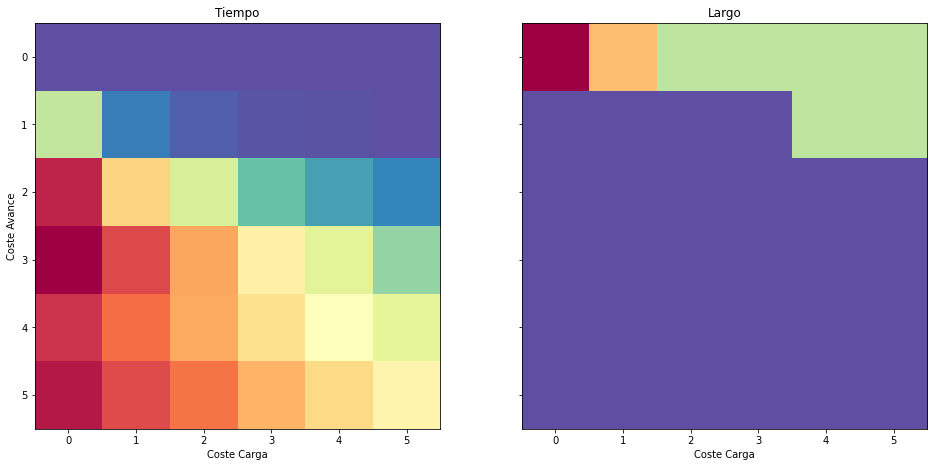

In [40]:
def evaluar():
    """
    Funcion para realizar la evaluación de los pesos para el calculo de rendimiento
    """
    agent = Agent(Rules().getRules(), INIT_STATE, GOAL_STATE)
    
    tiempos = np.zeros((6,6))
    largos = np.zeros((6,6))
    for (c_avance, c_carga),_ in np.ndenumerate(tiempos):
        start = time.time()
        result = agent.heuristicSearch(c_avance, c_carga)
        end = time.time()
        path = [] 
        while result is not None:
            path.insert(0,result.state)
            result = result.prevNode
            
        #for p in path: print(p)
        
        tiempos[c_avance, c_carga] = end - start
        largos[c_avance, c_carga] = len(path)
        print("COSTE AVANCE ->",c_avance, "COSTE CARGA INCORRECTA -> " ,c_carga, "LARGO -> ", largos[c_avance, c_carga], "Tiempo -> ", tiempos[c_avance, c_carga])
    
    f, axis = plt.subplots(1, 2, sharey=True, figsize=(16,10), sharex = True)
    axis[0].set_title("Tiempo")
    axis[0].set_ylabel('Coste Avance')
    axis[0].set_xlabel('Coste Carga')
    axis[1].set_title("Largo")
    axis[1].set_xlabel('Coste Carga')
    axis[0].imshow(tiempos,cmap=plt.cm.Spectral_r)
    axis[1].imshow(largos,cmap=plt.cm.Spectral_r)
    
    plt.show()
                    
evaluar()  

Vemos como el resultado más rápido que da el camino más corto lo obtenemos con el coste de movimiento = 1 y con el coste de carga mal colocada = 3. El resultado se genera en vídeo además de en las imagenes

In [20]:
main(c_avance = 1, c_carga = 3, video_title="PathFinder", True)

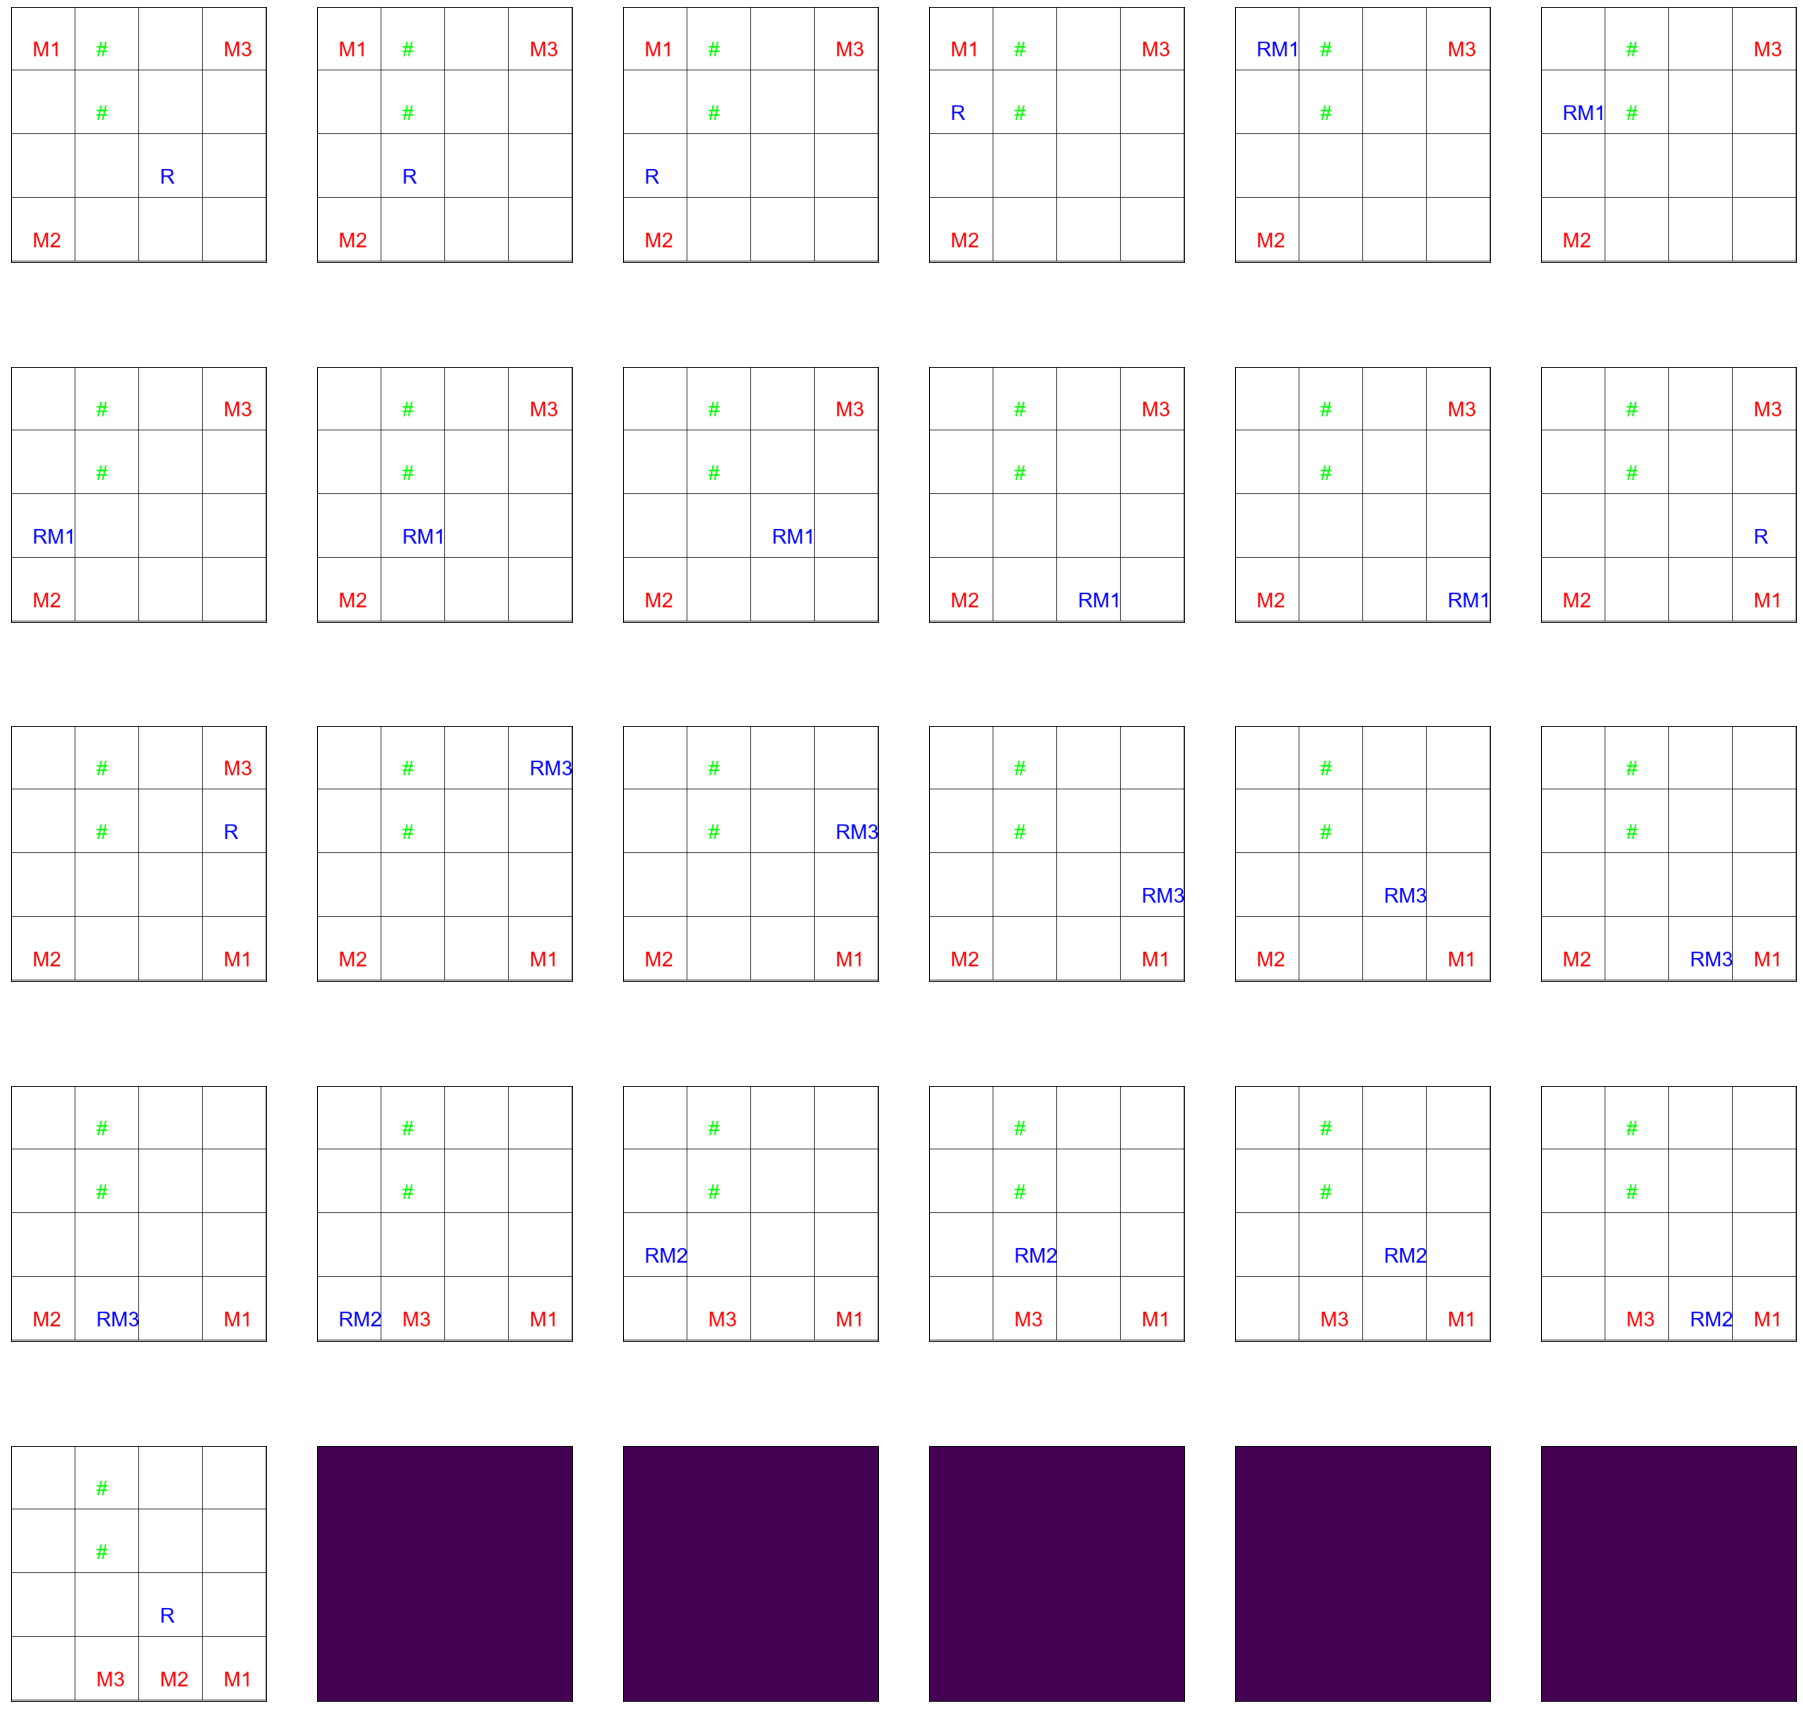

In [39]:
def MostrarResultado(images):
    """
    Muestra el resultado de la busqueda
    """
    img_list = list(images)
    fig, axis = plt.subplots(ncols = 6, nrows = 5, figsize=(32,32), sharex=False, sharey=False)
    imgIndex = 0
    imgLen = len(images)
    for rows in axis:
        for ax in rows:
            ax.set_xticks([])
            ax.set_yticks([])
            ax.margins(1,1)
            if imgLen > imgIndex:  
                ax.imshow(images[imgIndex])   
                imgIndex+=1
            else:
                ax.imshow(np.zeros((1,1)))

img_array = []
for filename in glob.glob("./VideoImages/PathFinder/*.png"):
    img = cv2.imread(filename)
    img_array.append(img)
MostrarResultado(img_array)

Otra de las pruebas que se ha realizado ha sido complicando el almacen añadiendo más cargas y paredes, vemos como lo soluciona también correctamente.
Como resultado generará un video con la resulución del problema

In [36]:
INIT_STATE = [["M1", "#",  "M4" , "M3"],
			  [ 0  , "#",  0 ,  0  ],
			  [ 0  , "#" , "R",  0  ],
			  ["M2",  0 ,  0 ,  0  ]]

GOAL_STATE = [[ 0 , "#" ,  0  ,  0  ],
			  [ 0 , "#" ,  0  ,  0  ],
			  [ 0 , "#" , "R" ,  0  ],
			  [ "M4", "M3", "M2", "M1"]]  

main(c_avance = 1, c_carga = 2, video_title="PathFinder2",save_historic= False)